# Baseline model : bicubic interpolation

In [1]:
from PIL import Image, ImageDraw, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
import os, shutil

In [2]:
dir_low_enhanced = 'data/enhanced/low'
dir_high_enhanced = 'data/enhanced/high'
in_size = (40, 120)
out_size = (80, 240)

In [3]:
def bicubic_upscale(image_num, plot=False):
    path = f"{dir_low_enhanced}/{str(image_num)}.png"
    
    # Check if file exists
    if not os.path.exists(path): 
        print(f"File not found: {path}")
        return None

    img = Image.open(path)
    # Handle transparency or palette modes by converting to RGB
    img = img.convert('RGB') if img.mode in ['P', 'RGBA'] else img

    # Upscale & Sharpen (Bicubic Resampling)
    # Note: Ensure 'out_size' is defined in your global scope or passed as an argument
    up = img.resize(out_size, resample=Image.Resampling.BICUBIC)

    if plot:
        plt.figure(figsize=(12, 6)) # Set global figure size

        # Subplot 1: Before
        plt.subplot(1, 2, 1) # 1 row, 2 columns, index 1
        plt.imshow(img, cmap='gray')
        plt.title(f"Before (Original)\nSize: {img.size}")
        plt.axis('off') # Hide X/Y axes

        # Subplot 2: After
        plt.subplot(1, 2, 2) # 1 row, 2 columns, index 2
        plt.imshow(up, cmap='gray')
        plt.title(f"After (Bicubic)\nSize: {up.size}")
        plt.axis('off')

        plt.tight_layout() # Prevent title overlap
        plt.show()

    return up

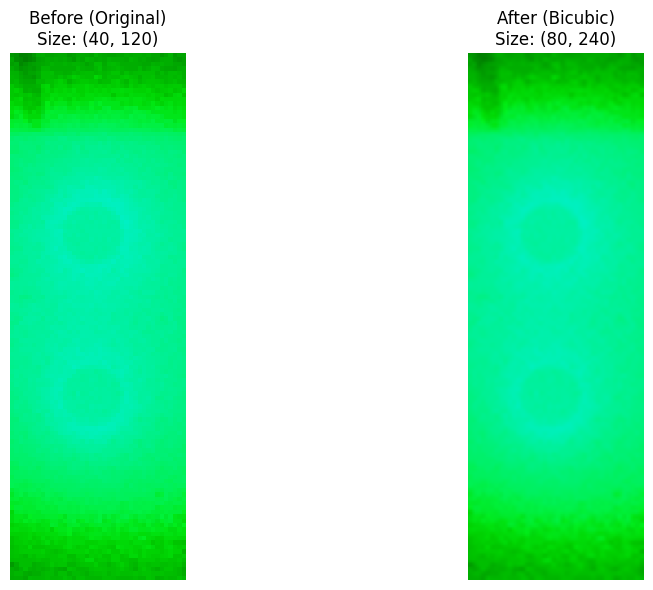

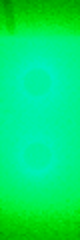

In [4]:
bicubic_upscale(0, plot=True)

In [17]:
from PIL import Image
def bicubic_upscale_filter(image_num, plot=False):
    path = f"{dir_low_enhanced}/{str(image_num)}.png"
    
    if not os.path.exists(path): 
        return None

    img = Image.open(path)
    if img.mode in ['P', 'RGBA']:
        img = img.convert('RGB')

    up = img.resize(out_size, resample=Image.Resampling.BICUBIC)
    
    # Application du filtre passe-haut (Sharpening)
    up_hf = up.filter(ImageFilter.UnsharpMask(radius=2, percent=3000, threshold=1))

    up = Image.blend(up, up_hf, alpha=0.6)
    if plot:
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Original: (40, 128)")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(up, cmap='gray')
        plt.title(f"Upscaled & Filtered: (80, 256)")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    return up

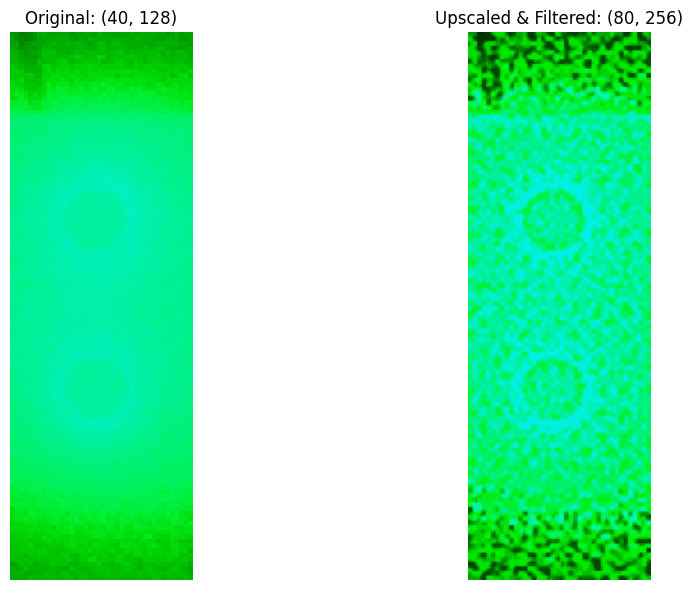

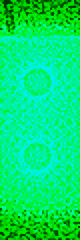

In [18]:
bicubic_upscale_filter(0, plot=True)